
# Political Social Media — Data Cleaning & Preprocessing Demo

This notebook walks through a practical preprocessing pipeline for social media data:

1. Load & inspect  
2. Drop irrelevant columns  
3. Handle missing values  
4. Feature extraction from raw text  
5. Text cleaning (normalized copy)  
6. Outlier inspection (confidence columns)  
7. Normalization (Min–Max)  
8. Encode categoricals  
9. Stratified sampling (by `bias`)  
10. Save artifacts


In [ ]:

# Setup: imports and matplotlib
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

SRC = "/content/drive/MyDrive/CS 4230/political_social_media.csv"


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1) Load & Inspect

In [ ]:

# Robust CSV loader with fallback encodings
def robust_read_csv(path):
    for enc in ["utf-8", "cp1252", "ISO-8859-1"]:
        try:
            return pd.read_csv(path, encoding=enc, on_bad_lines="skip")
        except Exception as e:
            last = f"{enc}: {type(e).__name__}: {e}"
    raise RuntimeError("Failed to load CSV. Last error: " + last)

df = robust_read_csv(SRC)

#Inspecting the dataset
print("Shape:", df.shape) #number of rows and columns
print("Columns:", list(df.columns)) #prints all column names
print(df.dtypes) #shows the data types of each column

#checking data quality
print("\nMissing values (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10)) # counts how many missing (NaN) values are in each column and sorts so that columns with the most missing values appear first.
print("\nDuplicate rows:", df.duplicated().sum()) # returns a Boolean for each row (True if duplicate) and .sum() → counts how many duplicates there are.

df.head(3) #shows the first 3 rows of the dataframe


Shape: (5000, 21)
Columns: ['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'audience', 'audience:confidence', 'bias', 'bias:confidence', 'message', 'message:confidence', 'orig__golden', 'audience_gold', 'bias_gold', 'bioid', 'embed', 'id', 'label', 'message_gold', 'source', 'text']
_unit_id                 int64
_golden                   bool
_unit_state             object
_trusted_judgments       int64
_last_judgment_at       object
audience                object
audience:confidence    float64
bias                    object
bias:confidence        float64
message                 object
message:confidence     float64
orig__golden           float64
audience_gold          float64
bias_gold              float64
bioid                   object
embed                   object
id                      object
label                   object
message_gold           float64
source                  object
text                    object
dtype: object

Missing values (t

,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,audience,audience:confidence,bias,bias:confidence,message,...,orig__golden,audience_gold,bias_gold,bioid,embed,id,label,message_gold,source,text
0,766192484,False,finalized,1,8/4/15 21:17,national,1.0,partisan,1.0,policy,...,NaN,NaN,NaN,R000596,"<blockquote class=""twitter-tweet"" width=""450"">...",3.83249E+17,From: Trey Radel (Representative from Florida),NaN,twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,766192485,False,finalized,1,8/4/15 21:20,national,1.0,partisan,1.0,attack,...,NaN,NaN,NaN,M000355,"<blockquote class=""twitter-tweet"" width=""450"">...",3.11208E+17,From: Mitch McConnell (Senator from Kentucky),NaN,twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,766192486,False,finalized,1,8/4/15 21:14,national,1.0,neutral,1.0,support,...,NaN,NaN,NaN,S001180,"<blockquote class=""twitter-tweet"" width=""450"">...",3.39069E+17,From: Kurt Schrader (Representative from Oregon),NaN,twitter,Please join me today in remembering our fallen...


## 2) Drop Irrelevant/Technical Columns

In [ ]:
# create a copy
work = df.copy()

drop_cols = [c for c in work.columns if "gold" in c.lower()]  # *_gold, orig__golden
drop_cols += [c for c in work.columns if c.startswith("_")]   # task/mturk-style metadata
drop_cols += [c for c in ["embed"]]                            # raw HTML embeds
drop_cols = sorted(set([c for c in drop_cols if c in work.columns])) # set() removes duplicates (in case a column matched multiple filters).

work = work.drop(columns=drop_cols) # drops columns liseted in drop_cols
print("Dropped columns:", drop_cols)
print("Shape now:", work.shape) #new dataframe shape
work.head(3)


Dropped columns: ['_golden', '_last_judgment_at', '_trusted_judgments', '_unit_id', '_unit_state', 'audience_gold', 'bias_gold', 'embed', 'message_gold', 'orig__golden']
Shape now: (5000, 11)


,audience,audience:confidence,bias,bias:confidence,message,message:confidence,bioid,id,label,source,text
0,national,1.0,partisan,1.0,policy,1.0,R000596,3.83249E+17,From: Trey Radel (Representative from Florida),twitter,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...
1,national,1.0,partisan,1.0,attack,1.0,M000355,3.11208E+17,From: Mitch McConnell (Senator from Kentucky),twitter,VIDEO - #Obamacare: Full of Higher Costs and ...
2,national,1.0,neutral,1.0,support,1.0,S001180,3.39069E+17,From: Kurt Schrader (Representative from Oregon),twitter,Please join me today in remembering our fallen...


## 3) Handle Missing Values

In [ ]:

# Ensure text column exists and drop rows without text (can't model tweets without text)
if "text" not in work.columns:
    raise ValueError("Expected 'text' column not found.")

before = work.shape[0]
work = work[~work["text"].isna()].copy() # This step removes tweets with no content since you can’t analyze or model empty text.
after = work.shape[0]
print("Dropped rows with missing text:", before - after)

# Fill common categoricals with explicit 'unknown' for pedagogy
for col in ["bias", "audience", "message", "source"]:
    if col in work.columns:
        work[col] = work[col].fillna("unknown")

# Keep NaNs in confidence columns for discussion/imputation during scaling (in step 7)
conf_cols = [c for c in work.columns if c.endswith(":confidence")]
conf_cols


Dropped rows with missing text: 0


['audience:confidence', 'bias:confidence', 'message:confidence']

## 4) Feature Extraction (from Raw Text)

In [ ]:

# Define helper functions to count text patterns
def count_hashtags(s): return 0 if not isinstance(s,str) else len(re.findall(r"#\w+", s)) #Uses a regular expression (r"#\w+") to find all hashtag tokens (words starting with #).
def count_mentions(s): return 0 if not isinstance(s,str) else len(re.findall(r"@\w+", s)) #Finds all user mentions (words starting with @)
def count_urls(s):     return 0 if not isinstance(s,str) else len(re.findall(r"https?://\S+|www\.\S+", s)) #Finds URLs or web links using a regex that matches either http://, https://, or www. patterns.
def count_exclaims(s): return 0 if not isinstance(s,str) else s.count("!")
def word_count(s):     return 0 if not isinstance(s,str) else len(s.split())

#apply functions to the text column
work["hashtag_count"] = work["text"].apply(count_hashtags)
work["mention_count"] = work["text"].apply(count_mentions)
work["url_count"]     = work["text"].apply(count_urls)
work["exclaim_count"] = work["text"].apply(count_exclaims)
work["word_count"]    = work["text"].apply(word_count)

work[["hashtag_count","mention_count","url_count","exclaim_count","word_count"]].describe()


,hashtag_count,mention_count,url_count,exclaim_count,word_count
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.502600,0.368800,0.455000,0.199000,31.569600
std,0.847193,0.777243,0.560391,0.494214,51.424897
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,16.000000
50%,0.000000,0.000000,0.000000,0.000000,20.000000
75%,1.000000,0.000000,1.000000,0.000000,32.000000
max,8.000000,9.000000,12.000000,7.000000,2626.000000


## 5) Text Cleaning (Normalized Copy)

In [ ]:

#define regular expressions
# These compiled regexes make text replacement faster and cleaner when called repeatedly in the function.
URL_RE  = re.compile(r"https?://\S+|www\.\S+")  # matches URLs
MENT_RE = re.compile(r"@\w+")       # matches mentions
HASH_RE = re.compile(r"#")           # remove symbol, keep token
PUNC_RE = re.compile(r"[^\w\s]")   # keep letters/numbers/underscore and spaces

def clean_tweet(text):
    if not isinstance(text, str): return ""
    t = text.lower()
    t = URL_RE.sub(" ", t) #replaces url with a space
    t = MENT_RE.sub(" ", t)
    t = HASH_RE.sub("", t)
    t = PUNC_RE.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

work["text_clean"] = work["text"].apply(clean_tweet)
work[["text","text_clean"]].head(5)


,text,text_clean
0,RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,rt rep trey radel r fl slams obamacare politics
1,VIDEO - #Obamacare: Full of Higher Costs and ...,video obamacare full of higher costs and broke...
2,Please join me today in remembering our fallen...,please join me today in remembering our fallen...
3,RT @SenatorLeahy: 1st step toward Senate debat...,rt 1st step toward senate debate on leahy crap...
4,.@amazon delivery #drones show need to update ...,delivery drones show need to update law to pro...


## 6) Outlier Inspection (Confidence Columns)


=== Boxplot Statistics for audience:confidence ===
Count: 5000
Min: 0.505
25% (Q1): 1.000
Median (Q2): 1.000
75% (Q3): 1.000
Max: 1.000
IQR (Q3 - Q1): 0.000
Lower whisker: 1.000
Upper whisker: 1.000
Outliers: 51 values
Example outliers: [0.5426, 0.5085, 0.5461, 0.5455, 0.5556]


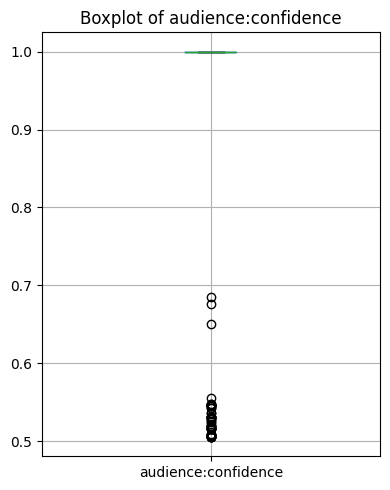


=== Boxplot Statistics for bias:confidence ===
Count: 5000
Min: 0.502
25% (Q1): 1.000
Median (Q2): 1.000
75% (Q3): 1.000
Max: 1.000
IQR (Q3 - Q1): 0.000
Lower whisker: 1.000
Upper whisker: 1.000
Outliers: 65 values
Example outliers: [0.5216, 0.5085, 0.5556, 0.5294, 0.5461]


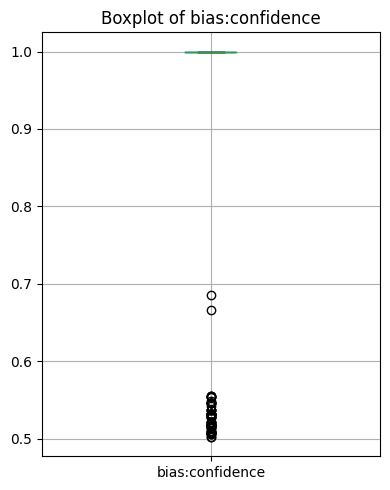


=== Boxplot Statistics for message:confidence ===
Count: 5000
Min: 0.502
25% (Q1): 1.000
Median (Q2): 1.000
75% (Q3): 1.000
Max: 1.000
IQR (Q3 - Q1): 0.000
Lower whisker: 1.000
Upper whisker: 1.000
Outliers: 41 values
Example outliers: [0.5085, 0.5426, 0.6849, 0.5085, 0.5308]


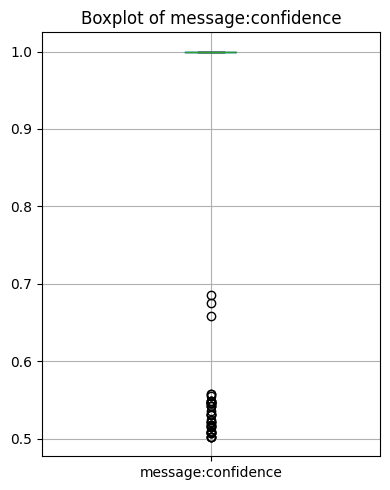

In [ ]:

# Loop through numeric confidence columns
for c in [c for c in conf_cols if c in work.columns and pd.api.types.is_numeric_dtype(work[c])]:

    # Drop NaNs before describing
    col_data = work[c].dropna()

    # Compute boxplot statistics using pandas describe()
    stats = col_data.describe(percentiles=[0.25, 0.5, 0.75])
    iqr = stats["75%"] - stats["25%"]
    lower_whisker = max(col_data.min(), stats["25%"] - 1.5 * iqr)
    upper_whisker = min(col_data.max(), stats["75%"] + 1.5 * iqr)
    outliers = col_data[(col_data < lower_whisker) | (col_data > upper_whisker)]

    # Print statistics summary
    print(f"\n=== Boxplot Statistics for {c} ===")
    print(f"Count: {int(stats['count'])}")
    print(f"Min: {stats['min']:.3f}")
    print(f"25% (Q1): {stats['25%']:.3f}")
    print(f"Median (Q2): {stats['50%']:.3f}")
    print(f"75% (Q3): {stats['75%']:.3f}")
    print(f"Max: {stats['max']:.3f}")
    print(f"IQR (Q3 - Q1): {iqr:.3f}")
    print(f"Lower whisker: {lower_whisker:.3f}")
    print(f"Upper whisker: {upper_whisker:.3f}")
    print(f"Outliers: {len(outliers)} values")
    if len(outliers) > 0:
        print(f"Example outliers: {outliers.head(5).tolist()}")

    # Generate boxplot visualization
    plt.figure(figsize=(4, 5))
    work[[c]].boxplot()
    plt.title(f"Boxplot of {c}")
    plt.tight_layout()
    plt.show()


## 7) Normalization (Min–Max on Confidence Columns)

In [ ]:

scaler = MinMaxScaler() #Imports a Min-Max scaler from sklearn.preprocessing
scaled_cols = []

for c in conf_cols:
    if c in work.columns and pd.api.types.is_numeric_dtype(work[c]): #Check that the column exists and is numeric
        vals = work[[c]].values #Extract the column values as a NumPy array
        if np.isnan(vals).all(): #Skip column if all values are missing
            continue
        col_median = np.nanmedian(vals) #Compute median for imputation
        vals_imputed = np.where(np.isnan(vals), col_median, vals) #Impute missing values with the median
        scaled = scaler.fit_transform(vals_imputed) #Apply Min–Max normalization
        newc = c.replace(":confidence", "_conf_scaled") #Create a new column name for the scaled data
        work[newc] = scaled #Add the new scaled column to the DataFrame
        scaled_cols.append(newc) #Keep track of which columns were scaled

scaled_cols


['audience_conf_scaled', 'bias_conf_scaled', 'message_conf_scaled']

## 8) Encode Categoricals

In [ ]:
# Identify available categorical columns
cat_cols = [c for c in ["bias", "audience", "message", "source"] if c in work.columns]
print("Categorical columns found:", cat_cols)

if len(cat_cols) > 0:
    # Ensure these columns are strings
    for c in cat_cols:
        work[c] = work[c].astype(str)

    # Create dummy variables (one-hot encoding)
    encoded = pd.get_dummies(work[cat_cols], prefix=cat_cols, drop_first=False)

    # Drop original categorical columns and add encoded ones
    work = pd.concat([work.drop(columns=cat_cols), encoded], axis=1)

    print("Encoding complete.")
    print("Encoded shape:", encoded.shape)
    print("Final dataset shape:", work.shape)
else:
    print("No categorical columns found to encode.")

[c for c in work.columns if any(c.startswith(x + "_") for x in ["bias", "audience", "message", "source"])][:10]



Categorical columns found: ['bias', 'audience', 'message', 'source']
Encoding complete.
Encoded shape: (5000, 15)
Final dataset shape: (5000, 31)


['audience_conf_scaled',
 'bias_conf_scaled',
 'message_conf_scaled',
 'bias_neutral',
 'bias_partisan',
 'audience_constituency',
 'audience_national',
 'message_attack',
 'message_constituency',
 'message_information']

## 9) Stratified Sampling by `bias` (Pedagogical Subset)

In [ ]:

SAMPLED_PATH = "/content/drive/MyDrive/CS 4230/political_social_media_sampled_by_bias.csv"

if "bias" in df.columns:
    strata = df["bias"].fillna("unknown") #replaces missing values with unknown
    df_with_bias = work.copy() #make a copy of the working dataset
    df_with_bias["__bias_stratum"] = strata.values[:len(df_with_bias)] #Add the stratum labels to the copy

    #Group by bias and sample within each group
    sampled = (df_with_bias
               .groupby("__bias_stratum", group_keys=False)
               .apply(lambda g: g.sample(n=min(len(g), 100), random_state=42)))
    sampled.to_csv(SAMPLED_PATH, index=False) #Save the sampled dataset to Google Drive
    print("Saved stratified sample to:", SAMPLED_PATH)
    sampled.head(5)
else:
    print("No 'bias' column available for stratification.")


Saved stratified sample to: /content/drive/MyDrive/CS 4230/political_social_media_sampled_by_bias.csv


/tmp/ipython-input-997810375.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=min(len(g), 100), random_state=42)))


## 10) Save Artifacts

In [ ]:

CLEAN_PATH = "/content/drive/MyDrive/CS 4230/political_social_media_cleaned.csv"
work.to_csv(CLEAN_PATH, index=False)
print("Saved cleaned dataset to:", CLEAN_PATH)
work.head(5)


Saved cleaned dataset to: /content/drive/MyDrive/CS 4230/political_social_media_cleaned.csv


,audience:confidence,bias:confidence,message:confidence,bioid,id,label,text,hashtag_count,mention_count,url_count,...,message_constituency,message_information,message_media,message_mobilization,message_other,message_personal,message_policy,message_support,source_facebook,source_twitter
0,1.0,1.0,1.0,R000596,3.83249E+17,From: Trey Radel (Representative from Florida),RT @nowthisnews: Rep. Trey Radel (R- #FL) slam...,3,1,1,...,False,False,False,False,False,False,True,False,False,True
1,1.0,1.0,1.0,M000355,3.11208E+17,From: Mitch McConnell (Senator from Kentucky),VIDEO - #Obamacare: Full of Higher Costs and ...,1,0,1,...,False,False,False,False,False,False,False,False,False,True
2,1.0,1.0,1.0,S001180,3.39069E+17,From: Kurt Schrader (Representative from Oregon),Please join me today in remembering our fallen...,0,0,0,...,False,False,False,False,False,False,False,True,False,True
3,1.0,1.0,1.0,C000880,2.98528E+17,From: Michael Crapo (Senator from Idaho),RT @SenatorLeahy: 1st step toward Senate debat...,1,1,0,...,False,False,False,False,False,False,True,False,False,True
4,1.0,1.0,1.0,U000038,4.07643E+17,From: Mark Udall (Senator from Colorado),.@amazon delivery #drones show need to update ...,4,1,1,...,False,False,False,False,False,False,True,False,False,True
